In [19]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [20]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [21]:
from __future__ import print_function
from numpy import *
from scipy import *
import netCDF4 as nc
import numpy as np
import scipy as sp
import seawater
import datetime as dt

""
from salishsea_tools import (
    nc_tools,
    viz_tools, 
    geo_tools,
    tidetools
)
from salishsea_tools import visualisations as vis
import matplotlib.pyplot as plt
#matplotlib.use('Agg')
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
sys.path.append('/data/tjarniko/MEOPAR/tools/SalishSeaTools/salishsea_tools/')
import mocsy
import river_201702 as rv
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
import datetime as dt

%matplotlib inline

In [22]:
def make_nclen(start,end,ftype, sdir):
    date_ar = []
    sens_ar = []
    doy_ar = []
    start_run = arrow.get(start)
    end_run = arrow.get(end)
    arrow_array = []
    for r in arrow.Arrow.span_range('day', start_run, end_run):
        arrow_array.append(r)

    dayslen = len(arrow_array)
    for i in range(0,dayslen):
        tdate = arrow_array[i][0]
        ddmmmyy = tdate.format('DDMMMYY').lower()
        ymd = tdate.format('YYYYMMDD')
        dddd = tdate.format('DDDD')
        nc_sens = sdir + '/SKOG_1d_*'+ ftype +'*' + ymd + '-' + ymd + '.nc'
        tnc_sens = glob.glob(nc_sens)
        sens_ar.append(tnc_sens[0])
        date_ar.append(ddmmmyy)
        doy_ar.append(dddd)
    return date_ar, sens_ar, doy_ar

In [23]:
def make_avgthwg_plot(start,end,sdir_PI, sdir_BR, figstr):
    yr_s = int(start[0:4])
    mon_s = int(start[5:7])
    day_s = int(start[8:10])

    yr_e = int(end[0:4])
    mon_e = int(end[5:7])
    day_e = int(end[8:10])

    st = dt.datetime(yr_s,mon_s,day_s)
    en = dt.datetime(yr_e,mon_e,day_e)
    
    y_st = st.timetuple().tm_yday
    print(y_st)
    y_en = en.timetuple().tm_yday
    print(y_en)
    ts_BR = np.arange(y_st,y_en+1,1)
    days_in = len(ts_BR)

    dates_preind_carp, files_preind_carp, doy_preind = make_nclen(start,end,'carp', sdir_PI)
    dates_br_carp, files_br_carp, doy_br = make_nclen(start,end,'carp', sdir_BR)
    dates_preind_grid, files_preind_grid, doy_preind = make_nclen(start,end,'grid_T', sdir_PI)
    dates_br_grid, files_br_grid, doy_br = make_nclen(start,end,'grid_T', sdir_BR)

    mon3_dic_BR = np.zeros([days_in,40,898,398])
    mon3_dic_PI = np.zeros([days_in,40,898,398])
    
    for i in range (0,days_in-1):
        if i%10 ==0:
            print(i)
        test_br_carp = nc.Dataset(files_br_carp[i])
        test_pi_carp = nc.Dataset(files_preind_carp[i])
        t_dic_br = np.squeeze(test_br_carp['dissolved_inorganic_carbon'][:])
        t_dic_pi = np.squeeze(test_pi_carp['dissolved_inorganic_carbon'][:])
        mon3_dic_BR[i,:,:,:] = t_dic_br
        mon3_dic_PI[i,:,:,:] = t_dic_pi

    mon3_dic_BR_av = np.mean(mon3_dic_BR,axis = 0)
    mon3_dic_PI_av = np.mean(mon3_dic_PI,axis = 0)
    
    bathy = nc.Dataset('/data/tjarniko/MEOPAR/grid/bathymetry_201702.nc')
    mesh = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')


    t_cmap = cm.cm.deep
    t_vmin = 2000
    t_vmax = 2300
    stepsize = 10
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(10,10))
    vis.contour_thalweg(ax1, mon3_dic_BR_av, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax1.set_title('BASE RUN 2015, averaged DIC: '+start+' - '+end , fontsize = 16)

    t_cmap = cm.cm.deep
    t_vmin = 2000
    t_vmax = 2300
    stepsize = 10
    vis.contour_thalweg(ax2, mon3_dic_PI_av, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax2.set_title('PREINDUSTRIAL RUN 2015, averaged DIC: '+start+' - '+end , fontsize = 16)
    t_cmap = cm.cm.balance
    t_vmin = -50
    t_vmax = 50
    stepsize = 1
    vis.contour_thalweg(ax3, mon3_dic_BR_av - mon3_dic_PI_av, bathy, mesh, np.arange(t_vmin, t_vmax, stepsize), cmap = t_cmap)
    ax3.set_title('BASE - PREINDUSTRIAL RUN 2015, averaged DIC: '+start+' - '+end, fontsize = 16)
    
    fig.tight_layout()
    plt.show()
    fig.savefig(figstr)


In [26]:
start1 = '2015-01-01'
end1 = '2015-02-28'

start2 = '2015-03-01'
end2 = '2015-04-30'

start3 = '2015-05-01'
end3 = '2015-07-31'

start4 = '2015-08-01'
end4 = '2015-10-31'

start5 = '2015-11-01'
end5 = '2015-12-29'

sdir_preind = '/data/tjarniko/results/PREIND_2nd_2015/PI_2/ncs/'
sdir_br = '/data/tjarniko/results/BR_2nd_2015_cop/SKOG_2/ncs/'

1
59
0
10
20
30
40
50


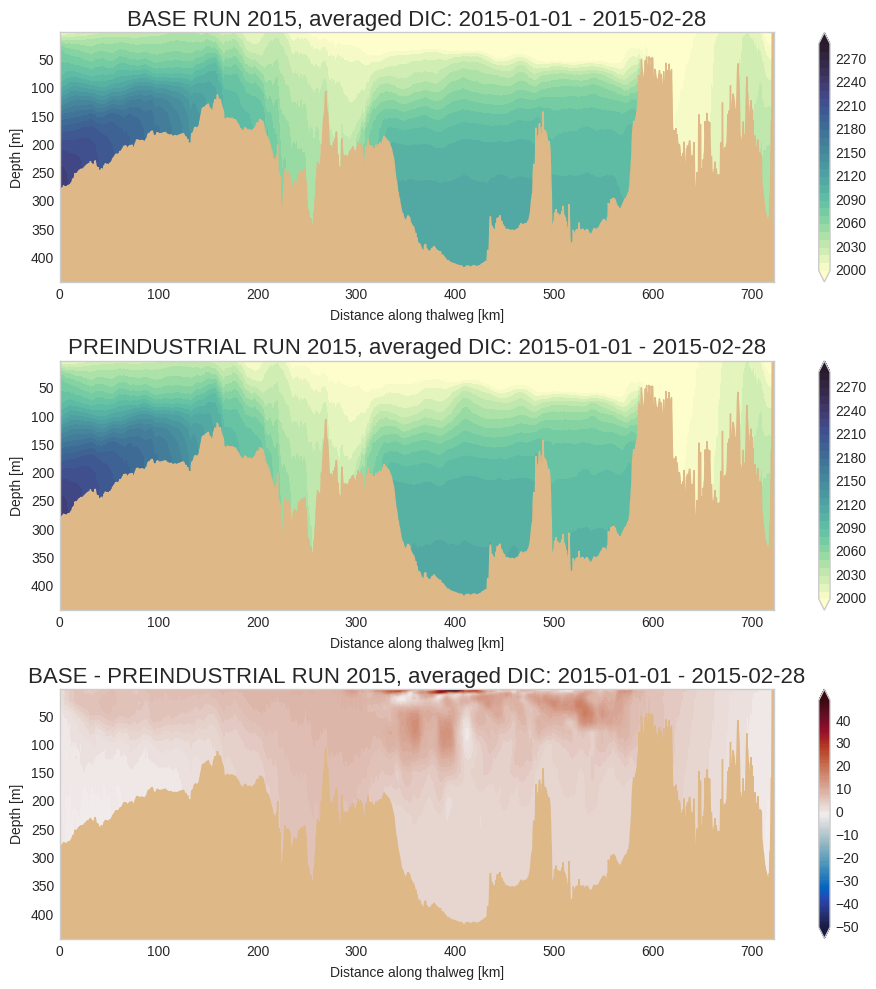

60
120
0
10
20
30
40
50


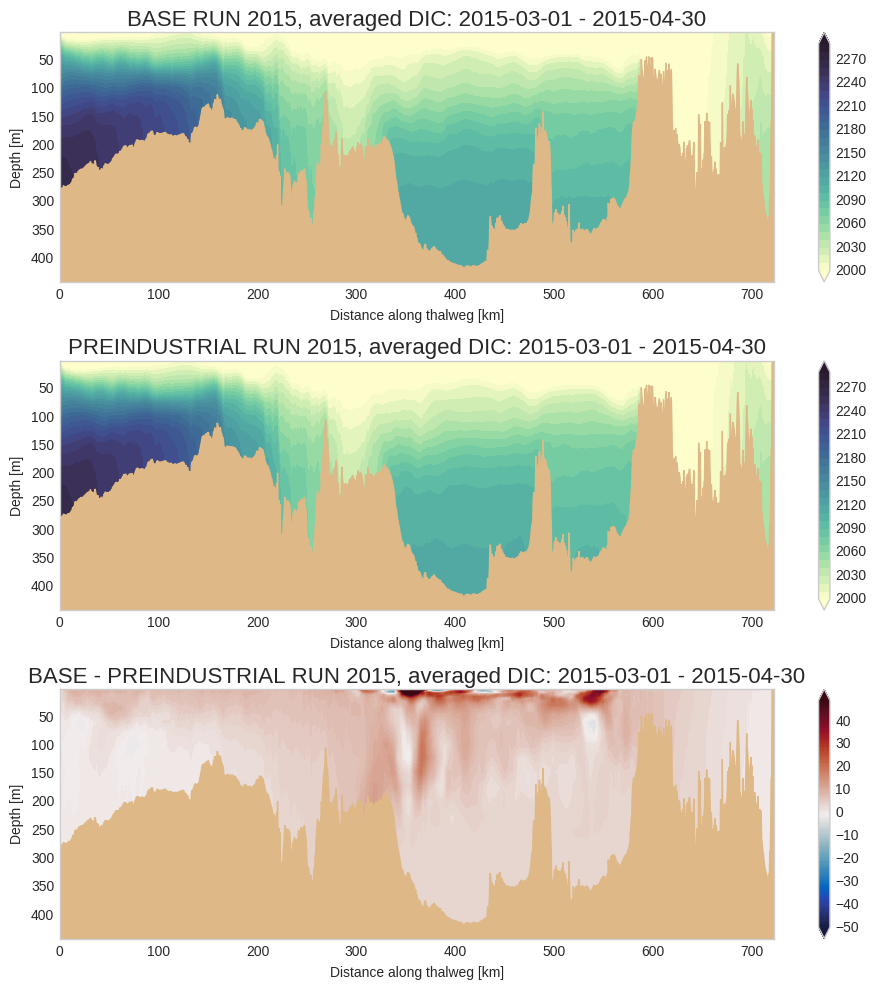

121
212
0
10
20
30
40
50
60
70
80
90


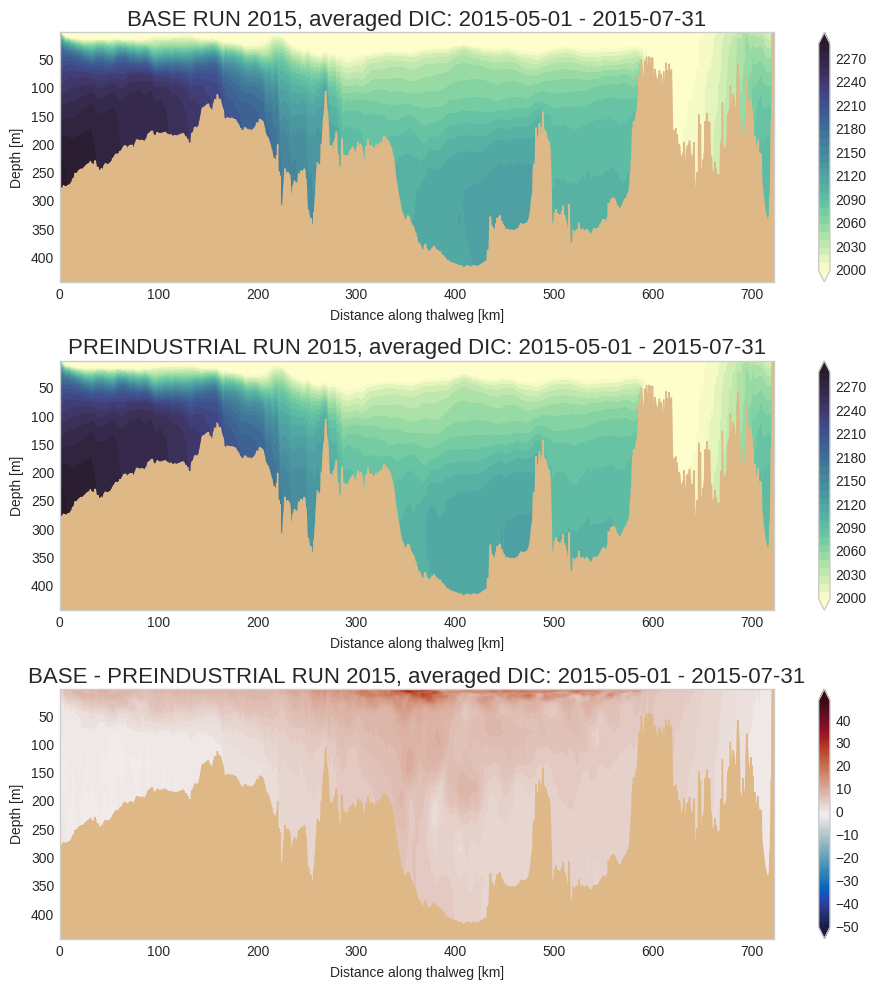

213
304
0
10
20
30
40
50
60
70
80
90


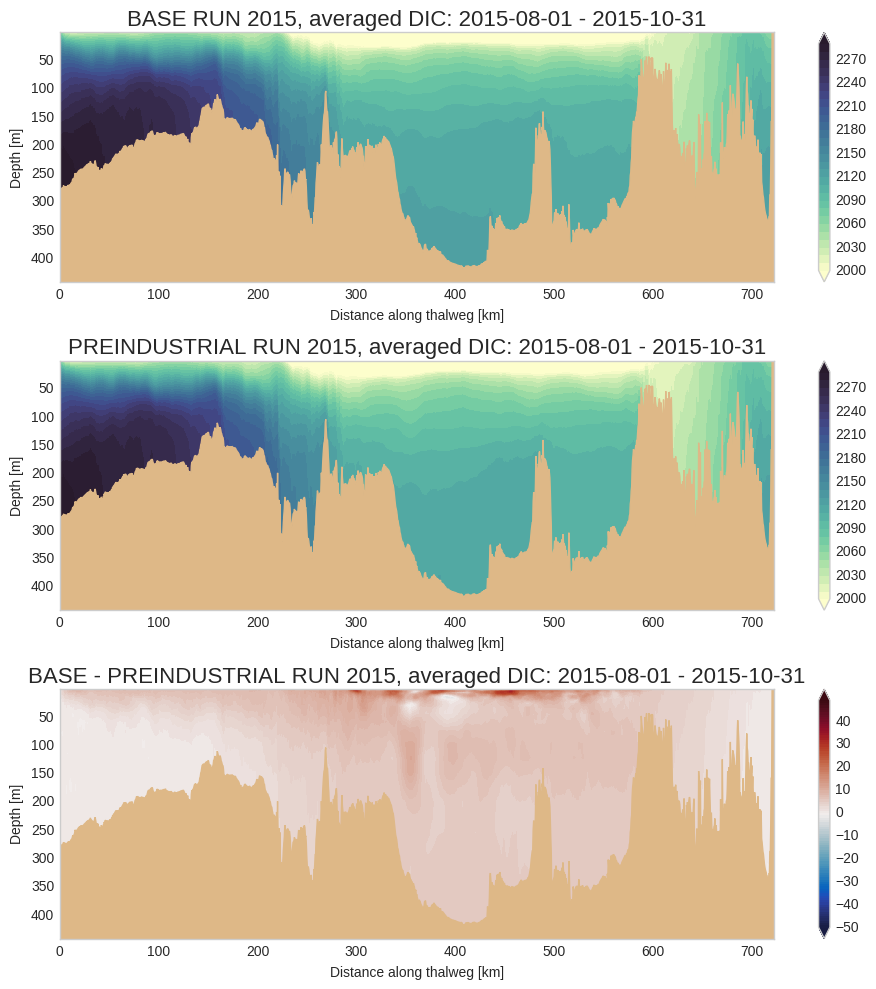

305
365


IndexError: list index out of range

In [25]:
make_avgthwg_plot(start1,end1,sdir_preind, sdir_br, 'JanFeb2015_DICdiff.jpg')
make_avgthwg_plot(start2,end2,sdir_preind, sdir_br, 'MarApr2015_DICdiff.jpg')
make_avgthwg_plot(start3,end3,sdir_preind, sdir_br, 'MayJul2015_DICdiff.jpg')
make_avgthwg_plot(start4,end4,sdir_preind, sdir_br, 'AugOct2015_DICdiff.jpg')


305
363
0
10
20
30
40
50


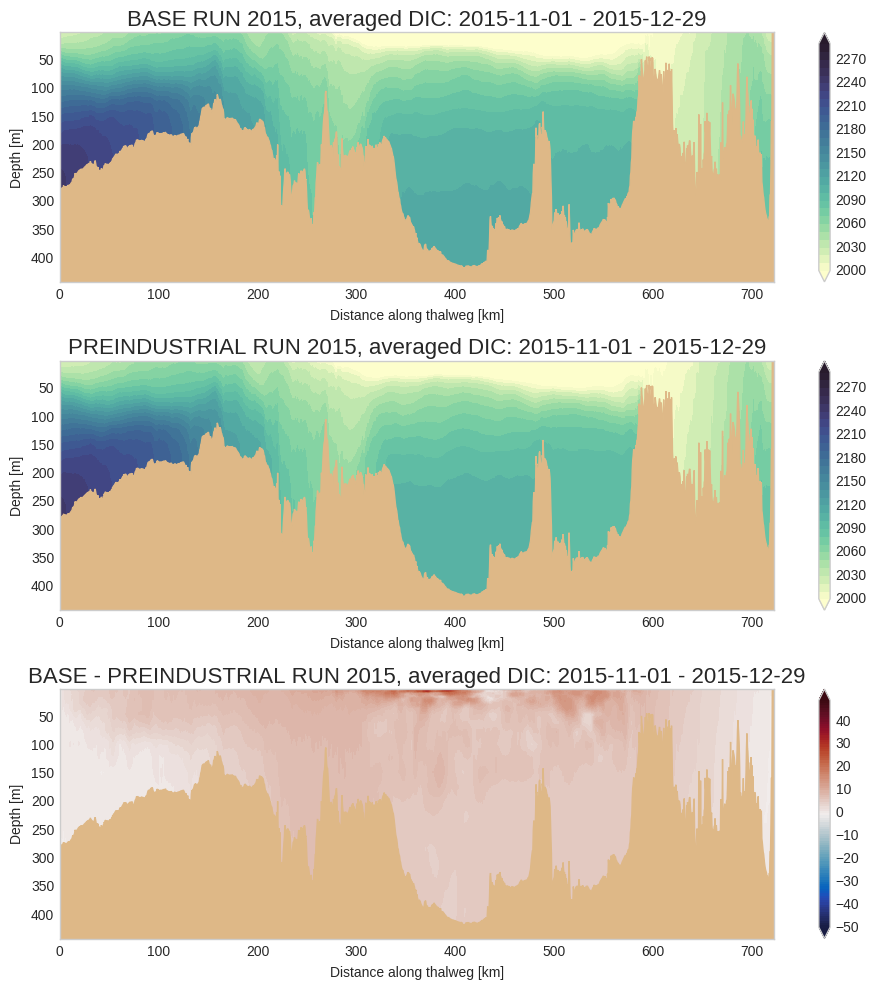

In [27]:
make_avgthwg_plot(start5,end5,sdir_preind, sdir_br, 'NovDec2015_DICdiff.jpg')